# TO DO
- Check if tweet has been made befor the creation date of the user account
- Decide the structure of this notebook (maybe current one could be too much rigid

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell

import math
import utils
import shutil as shl
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats import pearsonr

from datetime import datetime

In [2]:
#shl.unpack_archive("dataset/users.zip", "dataset") # unpacks the users.zip into the datasets folder (The users zip is small enough to be commited to github if we would like)
#shl.unpack_archive("dataset/tweets.zip", "dataset") # unpacks the tweets.zip into the datasets folder

In [2]:
#tweets_df = pd.read_csv("dataset/tweets_small.csv")
tweets_df = pd.read_csv("dataset/tweets.csv", usecols=["id", "user_id"])
#tweets_df = pd.read_csv("dataset/tweets.csv")
tweets_df.head()

,id,user_id
0,509354017856950272,327746321
1,583002592529121280,333722906
2,461498835362013185,2379755827
3,528808127366692864,466226882
4,575336690904006656,1355537995


In [3]:
from operator import index

users_df = pd.read_csv("dataset/users.csv")
#users_df.reset_index()
#users_df.head()

# Data Understanding

As you can see from comparing the table above and the function results below, we already have noticed that some values are not as expected. For example all the attributes below are states as objects, but we expect many of them to be numbers. This suggests that we will have to prepare and clean the data thouroghly before they can be used.

## Users Data

In [4]:
users_df.head()

,id,name,lang,bot,created_at,statuses_count
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54.0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3.0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50.0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085.0


### Assessing and fixing data quality

In [5]:
users_df.describe()

,id,bot,statuses_count
count,1.150800e+04,11508.000000,11109.000000
mean,1.274517e+09,0.531456,5883.312359
std,9.354135e+08,0.499031,19073.007305
min,6.780330e+05,0.000000,0.000000
25%,4.663594e+08,0.000000,41.000000
50%,1.128643e+09,1.000000,68.000000
75%,2.357148e+09,1.000000,2916.000000
max,3.164942e+09,1.000000,399555.000000


In [6]:
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5 MB


We observe that the created_at coloumn is recognized by pandas as an object, and not as a datetime as we would expect from this attribute. We check the values for null values.

In [12]:
users_df.isnull().any()

id                False
name               True
lang              False
bot               False
created_at        False
statuses_count     True
dtype: bool

In [29]:
# how to handle null values in statuses count? does it make sense to use mean/medien in a power law distribution? 

Clean created_at field, by converting string to datetime and checks if all the tweets were created after the first tweet published on twitter (so we don't have something strange like a tweet created in 01-01-1990)

In [13]:
# parsing string to datetime obj
users_df["created_at"] = pd.to_datetime(users_df["created_at"])

# checks if all the tweets were created after the first tweet published on twitter (so we don't have something strange like a tweet created in 01-01-1990)
twitter_first_tweet_datetime = datetime(2006,3,21,12,50,0)
#string_to_datetime = lambda string: datetime.strptime(string, expected_format)
published_after_twitter_first_tweet = lambda x: x > twitter_first_tweet_datetime
all(map(published_after_twitter_first_tweet, users_df["created_at"]))


True

let's see the unique number of ids and the actual number of ids...

In [14]:
num_unique_ids = len(pd.unique(users_df["id"]))
num_ids = len(users_df["id"])
print(f"number of unique IDs: {num_unique_ids} and number of IDs: {num_ids}")

number of unique IDs: 11508 and number of IDs: 11508


we could do a similar operation for the names, but people with the same name is not an error. For names it is more interesting to know how many values are missing in total.

In [15]:
def my_isnan(a):
    return a != a

def my_isempty(a):
    if a == "":
        return True


number_of_total_names = len(users_df["name"])
not_empty_or_missing_names = []
empty_or_missing_names = []
names_with_only_spaces = []

# iterate over all names looking for errors
for value in users_df["name"]:
    if my_isnan(value) or my_isempty(value): # name is nan or is_empty string
        #print(users_df["name"])
        #print(users_df["name"].index(value))
        empty_or_missing_names.append(value)
    if str(value).strip() == "":
            names_with_only_spaces.append(value)
            #users_df["name"].drop(index=value)
    elif not(my_isnan(value) or my_isempty(value)):
        #print(users_df["name"])
        #print(users_df["name"].index(value))
        not_empty_or_missing_names.append(value)
print(f" Number of total names = {number_of_total_names} vs total name values that are not NA or empty = {len(not_empty_or_missing_names)}")

"""
for value in users_df["name"]:
    if my_isnan(value) or my_isempty(value):
        #print(users_df["name"])
        #print(users_df["name"].index(value))
        empty_or_missing_names.append(value)
        #users_df["name"].drop(index=value)
    #else:
    #    not_empty_or_missing_names.append(value)
"""
print(f" Number of total names = {number_of_total_names} vs total name values that are NA or empty = {len(empty_or_missing_names)}")

#print(len(names_with_only_spaces))
#print(empty_or_missing_names)
#print(not_empty_or_missing_names)
#array_of_nan = np.isnan(users_df["name"])

#users_df["name"][1012]
#users_df["name"][0]
#empty_or_missing_names


 Number of total names = 11508 vs total name values that are not NA or empty = 11507


'\nfor value in users_df["name"]:\n    if my_isnan(value) or my_isempty(value):\n        #print(users_df["name"])\n        #print(users_df["name"].index(value))\n        empty_or_missing_names.append(value)\n        #users_df["name"].drop(index=value)\n    #else:\n    #    not_empty_or_missing_names.append(value)\n'

 Number of total names = 11508 vs total name values that are NA or empty = 1


The "lang" field is composed of [IETF language codes](https://en.wikipedia.org/wiki/IETF_language_tag). By selecting only the unique values it's possible to see that there are some erroneous values (e.g. "Select Language...", "xx-lc"); also, there are some values that are not properly correct (e.g. "zh-cn" instead of "zh-CN").

Since wrong values are just the 0.02% of the number of rows they are just dropped, while the other values are mapped to the correct ones.

In [22]:
wrong_fields = ["Select Language...", "xx-lc"] # only 3 elements
to_map_fields = {
    "en-gb": "en-GB",
    "zh-tw": "zh-TW",
    "zh-cn": "zh-CN",
    "fil": "fil-PH"
}

# dropping wrong fields
wrong_index = lambda x: True if x[1] in wrong_fields else False
wrong_indexes = [index for (index, _) in filter(wrong_index, enumerate(users_df["lang"]))]
users_df.drop(index=wrong_indexes, inplace=True)

# mapping incorrect values to fixed ones
for language in to_map_fields:
    indexes = users_df[users_df["lang"] == language].index
    for index in indexes:
        old_language = users_df.loc[index,"lang"]
        users_df.loc[index,"lang"] = to_map_fields[old_language]

array(['en', 'it', 'fr', 'ru', 'es', 'tr', 'en-GB', 'pt', 'nl', 'id',
       'zh-TW', 'ja', 'de', 'ko', 'en-AU', 'da', 'ar', 'zh-CN', 'pl',
       'el', 'fil-PH', 'sv'], dtype=object)

bot: should be yes or no; maybe there are wrong values?

In [17]:
pd.unique(users_df["bot"])

array([1, 0])

"created at" should be a time; check if there are type error or if time value is strange (e.g. tweet made before twitter release, which was march 21 2006)

In [18]:
# checks if all the datetime strings are in the valid format (YY-mm-dd H:M:S)
#expected_format = "%Y-%m-%d %H:%M:%S"
#is_datetime_format_correct = lambda x: utils.is_datetime_format_correct(x, expected_format)
#all(map(is_datetime_format_correct, users_df["created_at"]))



### Distribution of variables and statistics
Let's study them!

array([[<AxesSubplot:title={'center':'statuses_count'}>]], dtype=object)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

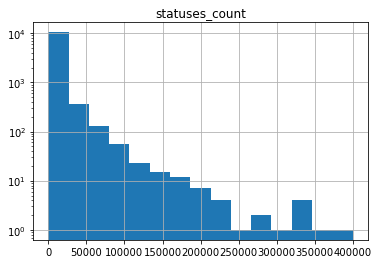

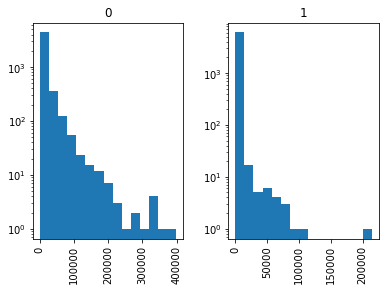

In [20]:
users_df.hist(
    column=["statuses_count"], 
    log=True, 
    bins=utils.get_sturges_bins(len(users_df["statuses_count"]))
)

users_df.hist(
    column=["statuses_count"], 
    by="bot", 
    log=True,
    bins=utils.get_sturges_bins(len(users_df["statuses_count"])) #FIX THIS: USES ALL THE SAMPLES, NOT JUST THE BOTS AND THE USERS
)

'\nget_language_frequency = lambda lang : len(users_df[users_df["lang"] == lang])\n\n# bar plot for language\n\nfreqs = [get_language_frequency(lang) for lang in langs]\n\nlangs_df = pd.DataFrame({"lang": langs, "freq": freqs})\nlangs_df.plot.bar(x="lang", y="freq", logy=True)\n'

<AxesSubplot:xlabel='lang'>

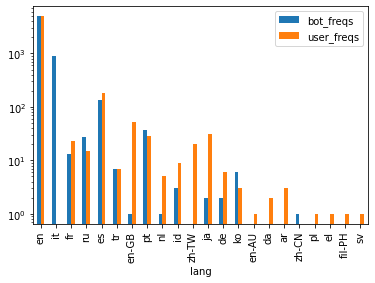

In [66]:
langs = pd.unique(users_df["lang"]) 
bot_freqs = []
user_freqs = []
for lang in langs:
    user_freqs.append(len(users_df.query(f"lang == '{lang}' & bot == 0")))
    bot_freqs.append(len(users_df.query(f"lang == '{lang}' & bot == 1")))

langs = pd.unique(users_df["lang"])
langs_df = pd.DataFrame({"lang": langs, "bot_freqs": bot_freqs, "user_freqs": user_freqs})
langs_df.plot.bar(x="lang", logy=True)

## Tweets data

### Assessing data quality

In [3]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 1 columns):
 #   Column  Non-Null Count     Dtype 
---  ------  --------------     ----- 
 0   id      13664694 non-null  object
dtypes: object(1)
memory usage: 964.8 MB


In [4]:
tweets_df.isnull().any() 

id    True
dtype: bool

keeping only the tweets with user_id in user dataset

In [32]:
user_ids = users_df["id"].values
user_ids.dtype
parsed_user_ids = pd.to_numeric(tweets_df["user_id"], errors="coerce")
parsed_user_ids.dtype
tweets_df[parsed_user_ids.isin(user_ids)]

dtype('int64')

dtype('float64')

,id,user_id
0,509354017856950272,327746321
1,583002592529121280,333722906
2,461498835362013185,2379755827
3,528808127366692864,466226882
4,575336690904006656,1355537995
...,...,...
13664691,588535254207467520,587491046
13664692,580420653666402304,1414080518
13664693,718157017970961,91781300
13664694,441301348676415488,127895572


clean id field by first removing nan values (just 2), then tring to cast to int and removing duplicates

In [19]:
#tweets_df.dropna(subset=["id"], inplace=True)

# removing not numeric strings
#pd.to_numeric(tweets_df["id"])

#tweets_df["id"].isin(users)

AttributeError: 'Series' object has no attribute 'is_numeric'

From the method above we observe that all our atributes except for "created_at" have one or more elements with null values.

In [8]:
"""
wrong_ids = []
for (i,k) in enumerate(df["id"]):
    if not isinstance(k, str) or not k.isnumeric():
        wrong_ids.append(i)
print(len(wrong_ids)/len(df["id"]))
""" 

'\nwrong_ids = []\nfor (i,k) in enumerate(df["id"]):\n    if not isinstance(k, str) or not k.isnumeric():\n        wrong_ids.append(i)\nprint(len(wrong_ids)/len(df["id"]))\n'

### Distribution of variables and statistics
Let's study them!

In [9]:
# should we use sturgen rule for number of bins?

# give error: ValueError: hist method requires numerical or datetime columns, nothing to plot.
#tweets_df.hist(column=["reply_count","retweet_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"])

In [10]:
tweets_df.describe()

,reply_count,num_urls,num_mentions
count,90.0,91.000000,90.000000
mean,0.0,0.142857,0.688889
std,0.0,0.382141,1.118229
min,0.0,0.000000,0.000000
25%,0.0,0.000000,0.000000
50%,0.0,0.000000,0.000000
75%,0.0,0.000000,1.000000
max,0.0,2.000000,7.000000


### Variables trasformations (?)

### Pairwise correlations